In [ ]:
!unzip data.zip -d .
! rm -rf data/train/none
! rm -rf data/validation/none

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.regularizers import l2

INPUT_SIZE = (128, 128)

model = Sequential()
model.add(Conv2D(8, 
                 (5, 5), 
                 input_shape=(INPUT_SIZE[0], INPUT_SIZE[1], 3), 
                 padding='same',
                 kernel_regularizer=l2(0.001), 
                 bias_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, 
                 (5, 5), 
                 padding='same',
                 kernel_regularizer=l2(0.001), 
                 bias_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 
                 (5, 5), 
                 padding='same',
                 kernel_regularizer=l2(0.001), 
                 bias_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 8)       608       
                                                                 
 activation (Activation)     (None, 128, 128, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        3216      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                    

In [3]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    # shear_range=0.1,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

# this is the augmentation configuration we will use for testing
test_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.001,
    height_shift_range=0.001,
    zoom_range=0.001,
    horizontal_flip=True
)

# this is a generator that will read pictures found in
# subfolders of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
    'data/train', 
    target_size=INPUT_SIZE, 
    # color_mode='grayscale',
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical'
)

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
    'data/validation',
    target_size=INPUT_SIZE,
    # color_mode='grayscale',
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1002 images belonging to 3 classes.
Found 317 images belonging to 3 classes.


In [4]:
from keras import callbacks

model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=".",
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples/batch_size,
    epochs=150,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples/batch_size,
    callbacks=[
        # callbacks.EarlyStopping(monitor='val_accuracy', patience=25),
        model_checkpoint_callback
    ]
)

Epoch 1/150
62/62 [==============================] - 13s 171ms/step - loss: 1.1393 - accuracy: 0.3493 - val_loss: 1.1251 - val_accuracy: 0.3438
Epoch 2/150
62/62 [==============================] - 8s 126ms/step - loss: 1.1191 - accuracy: 0.3683 - val_loss: 1.1205 - val_accuracy: 0.3438
Epoch 3/150
62/62 [==============================] - 10s 160ms/step - loss: 1.1105 - accuracy: 0.3942 - val_loss: 1.1809 - val_accuracy: 0.3502
Epoch 4/150
62/62 [==============================] - 10s 161ms/step - loss: 1.1069 - accuracy: 0.3942 - val_loss: 1.0985 - val_accuracy: 0.3912
Epoch 5/150
62/62 [==============================] - 10s 162ms/step - loss: 1.0801 - accuracy: 0.4501 - val_loss: 1.0801 - val_accuracy: 0.4353
Epoch 6/150
62/62 [==============================] - 8s 128ms/step - loss: 1.0372 - accuracy: 0.4860 - val_loss: 1.0798 - val_accuracy: 0.4322
Epoch 7/150
62/62 [==============================] - 8s 127ms/step - loss: 1.0002 - accuracy: 0.5200 - val_loss: 1.0734 - val_accuracy: 0.

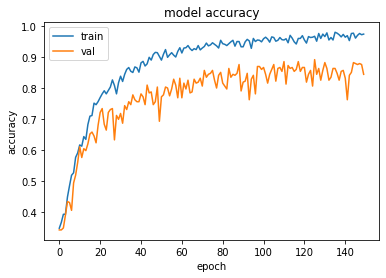

In [5]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [6]:
model.save("rps_homemade_model.h5")